### Libraries

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, MSELoss
from torch.optim import SGD, Adam, RAdam # Stochastic Gradient Descent, Adam and RAdam Optimiser
from torch.nn.init import xavier_uniform_, kaiming_uniform_ # weight initialiser: Xavier & He
from torchinfo import summary
from tqdm import tqdm, trange

%matplotlib inline

### Loading the Training dataset 

In [2]:
# read the dataset
file = "./weather_train.csv"
train_x = pd.read_csv(file)
train_x.info()
train_x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             15000 non-null  int64  
 1   DATE (YYYY/MM/DD)                      15000 non-null  object 
 2   MST                                    15000 non-null  object 
 3   Global CMP22 (vent/cor) [W/m^2]        15000 non-null  float64
 4   Direct sNIP [W/m^2]                    15000 non-null  float64
 5   Azimuth Angle [degrees]                15000 non-null  float64
 6   Tower Dry Bulb Temp [deg C]            15000 non-null  float64
 7   Tower Wet Bulb Temp [deg C]            15000 non-null  float64
 8   Tower Dew Point Temp [deg C]           15000 non-null  float64
 9   Tower RH [%]                           15000 non-null  float64
 10  Peak Wind Speed @ 6ft [m/s]            15000 non-null  float64
 11  Av

,Unnamed: 0,DATE (YYYY/MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,Albedo (CMP11),Cloud Type,Solar Zenith Angle,Snow Depth [cm]
0,0,2020/02/22,04:11,-1.12724,-0.365968,77.66760,8.210,0.388,-12.412,19.20,1.20,300.10,817.297,0.000,0.0,0.0000,0,50.16,9.460
1,1,2020/07/25,20:10,-1.04030,0.093816,304.73416,20.140,14.855,11.955,59.29,4.45,262.40,820.184,5.334,0.0,0.0000,7,57.39,1.121
2,2,2020/09/13,04:03,-1.29707,-0.251820,68.24852,14.080,6.560,-0.940,35.17,2.45,280.20,822.653,0.000,0.0,0.0000,8,65.63,-0.050
3,3,2020/03/08,15:25,79.20020,-0.014836,237.11811,15.030,5.725,-4.575,24.36,3.70,23.07,809.641,0.000,0.0,0.1587,6,57.08,0.734
4,4,2020/11/17,19:33,-1.61485,-0.459201,271.20406,12.660,3.180,-10.220,17.37,2.70,283.80,818.717,0.000,0.0,0.0000,0,128.59,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2020/04/20,18:47,3.69585,-0.553937,286.76511,13.280,5.410,-3.090,30.95,1.20,35.00,815.183,0.000,0.0,0.0000,0,91.76,0.954
14996,14996,2020/10/12,09:00,515.44400,912.832000,131.12291,16.980,5.677,-8.323,15.55,8.20,302.50,817.411,0.000,0.0,0.2326,0,44.57,-0.277
14997,14997,2020/12/31,09:20,286.39400,872.952000,140.97204,3.642,-1.619,-10.419,31.52,0.00,0.00,812.671,0.000,0.0,0.5277,3,82.88,2.426
14998,14998,2020/06/06,00:25,-1.38846,0.064190,6.62879,23.580,11.528,1.928,24.13,3.45,242.80,813.969,0.000,0.0,0.0000,0,133.73,0.777


### Loading the Testing dataset 

In [3]:
# read the dataset
file = "./weather_test.csv"
test_x = pd.read_csv(file)
test_x.info()
test_x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             2406 non-null   int64  
 1   DATE (YYYY/MM/DD)                      2406 non-null   object 
 2   MST                                    2406 non-null   object 
 3   Global CMP22 (vent/cor) [W/m^2]        2406 non-null   float64
 4   Direct sNIP [W/m^2]                    2406 non-null   float64
 5   Azimuth Angle [degrees]                2406 non-null   float64
 6   Tower Dry Bulb Temp [deg C]            2406 non-null   float64
 7   Tower Wet Bulb Temp [deg C]            2406 non-null   float64
 8   Tower Dew Point Temp [deg C]           2406 non-null   float64
 9   Tower RH [%]                           2406 non-null   float64
 10  Peak Wind Speed @ 6ft [m/s]            2406 non-null   float64
 11  Avg 

,Unnamed: 0,DATE (YYYY/MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,Albedo (CMP11),Cloud Type,Solar Zenith Angle
0,0,23/01/20,19:55,-0.821587,-0.197822,270.39668,0.344,-3.269,-9.469,43.43,1.95,300.70,817.643,0.000,0.0,0.0000,7,163.53
1,1,05/02/20,04:13,-0.464099,0.039564,83.18453,-15.420,-16.249,-19.649,67.07,1.20,308.30,809.469,0.000,0.0,0.0000,0,84.09
2,2,06/06/20,02:25,-1.133330,-0.009875,35.33772,22.380,11.522,3.122,28.25,1.70,214.00,813.392,0.000,0.0,0.0000,7,109.24
3,3,10/05/20,14:17,849.620000,946.128000,244.34737,14.240,6.585,-1.215,34.02,3.45,45.53,821.467,0.000,0.0,0.1844,7,156.80
4,4,11/12/20,15:41,44.193400,0.488831,230.89280,-5.580,-6.169,-7.269,86.40,1.20,15.69,812.324,0.000,1.0,0.6648,7,154.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,2401,16/11/20,21:21,-1.444170,-0.360447,292.96778,9.820,3.214,-4.886,33.41,1.70,272.00,824.536,0.000,0.0,0.0000,7,52.08
2402,2402,26/12/20,11:17,490.631000,996.863000,168.59312,14.500,3.446,-13.654,11.30,2.45,154.90,811.310,0.000,0.0,0.2381,3,75.61
2403,2403,09/04/20,00:08,-0.957105,-0.143412,1.93913,6.984,2.890,-1.610,53.41,2.70,22.43,820.148,0.000,0.0,0.0000,3,108.22
2404,2404,16/12/20,11:37,502.869000,978.244000,174.94429,4.311,-1.305,-10.505,29.84,8.70,287.10,814.018,0.000,0.0,0.6220,7,9.83


#### Function to check the output's Mean Absolute Error during validation

In [4]:
def MAE(y_out, valid_y):
    err = 0
    l = len(valid_y)
    if len(y_out) != l: 
        print("Length of the objects passed don't match.")
        return
    for i in range(l): err += np.abs(valid_y[i] - y_out[i])
    return err / l

### Primary Preprocessing

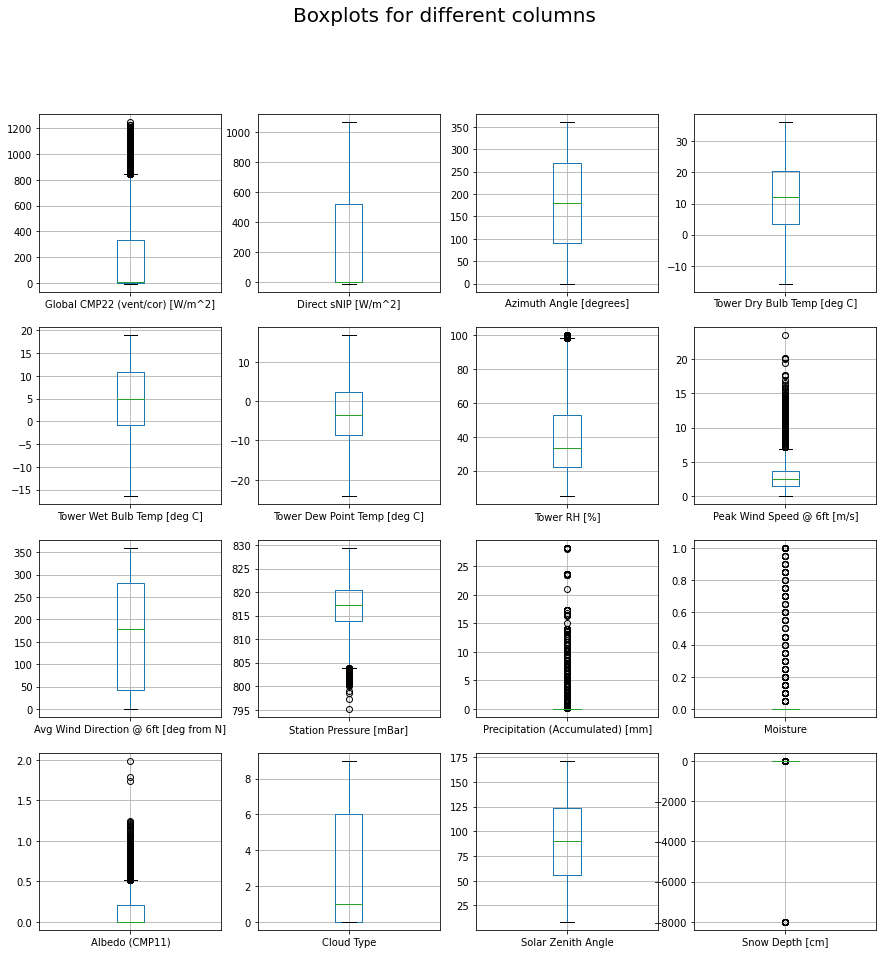

In [5]:
row = col = 4
heads = train_x.columns[3:]
fig = plt.figure(figsize = (15, 15))
fig.suptitle("Boxplots for different columns", fontsize = 20)
for i in range(16):
    fig.add_subplot(row, col, i + 1)
    img = train_x.boxplot(column = heads[i])

plt.show()

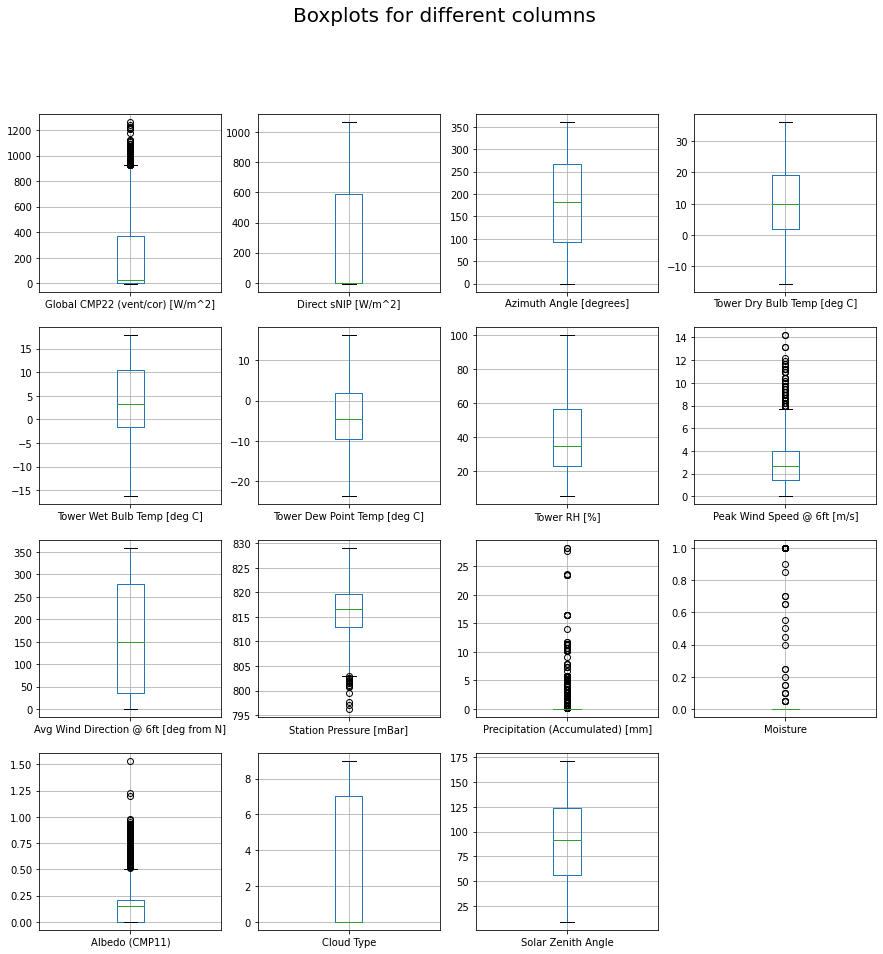

In [6]:
# test_x.boxplot(column = list(test_x.columns[3:]), rot = 90)
row = col = 4
heads = test_x.columns[3:]
fig = plt.figure(figsize = (15, 15))
fig.suptitle("Boxplots for different columns", fontsize = 20)
for i in range(15):
    fig.add_subplot(row, col, i + 1)
    img = test_x.boxplot(column = heads[i])

plt.show()

In [5]:
# drop the ID column
train_x.drop('Unnamed: 0', inplace = True, axis = 1)
test_x.drop('Unnamed: 0', inplace = True, axis = 1)

In [6]:
# 'Snow Depth [cm]' has some values negative, which is not possible
# So convert all nagative values to '0'
relu = lambda x: 0 if x < 0 else x
# for training dataset
train_x['Snow Depth [cm]'] = train_x['Snow Depth [cm]'].apply(relu)

<AxesSubplot:>

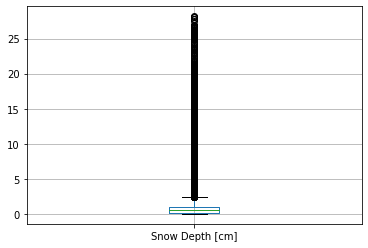

In [9]:
train_x.boxplot(column = train_x.columns[-1])

In [7]:
# handling the "DATE (YYYY/MM/DD)" column
daysAfterMonth = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
dayOfYear = lambda month, day: daysAfterMonth[month - 2] + day if month != 1 else day

# for training dataset
train_x['DATE (YYYY/MM/DD)'] = pd.to_datetime(train_x['DATE (YYYY/MM/DD)'])
month = train_x['DATE (YYYY/MM/DD)'].dt.month
day = train_x['DATE (YYYY/MM/DD)'].dt.day

month_day = pd.DataFrame(columns = ['month', 'day'])
month_day.month = month
month_day.day = day

train_x['DATE (YYYY/MM/DD)'] = month_day.apply(lambda x: dayOfYear(x.month, x.day), axis = 1)
train_x.rename(columns = {'DATE (YYYY/MM/DD)': 'Day_of_Year'}, inplace = True)

# for testing dataset
test_x['DATE (YYYY/MM/DD)'] = pd.to_datetime(test_x['DATE (YYYY/MM/DD)'])
month = test_x['DATE (YYYY/MM/DD)'].dt.month
day = test_x['DATE (YYYY/MM/DD)'].dt.day

month_day = pd.DataFrame(columns = ['month', 'day'])
month_day.month = month
month_day.day = day

test_x['DATE (YYYY/MM/DD)'] = month_day.apply(lambda x: dayOfYear(x.month, x.day), axis = 1)
test_x.rename(columns = {'DATE (YYYY/MM/DD)': 'Day_of_Year'}, inplace = True)

In [8]:
# handling the "MST" column
def partOfDay(hour):
    hour = int(hour.split(':')[0])
    if hour in [2,3,4,5]: return 0 # dawn 
    elif hour in [6,7,8,9]: return 1 # morning
    elif hour in [10,11,12,13]: return 2 # noon
    elif hour in [14,15,16,17]: return 3 # afternoon
    elif hour in [18,19,20,21]: return 4 # evening
    else: return 5 #midnight

# for training dataset
train_x['MST'] = train_x['MST'].apply(partOfDay)
train_x.rename(columns = {'MST': 'Part_Of_Day'}, inplace = True)

# for testing dataset
test_x['MST'] = test_x['MST'].apply(partOfDay)
test_x.rename(columns = {'MST': 'Part_Of_Day'}, inplace = True)

<AxesSubplot:>

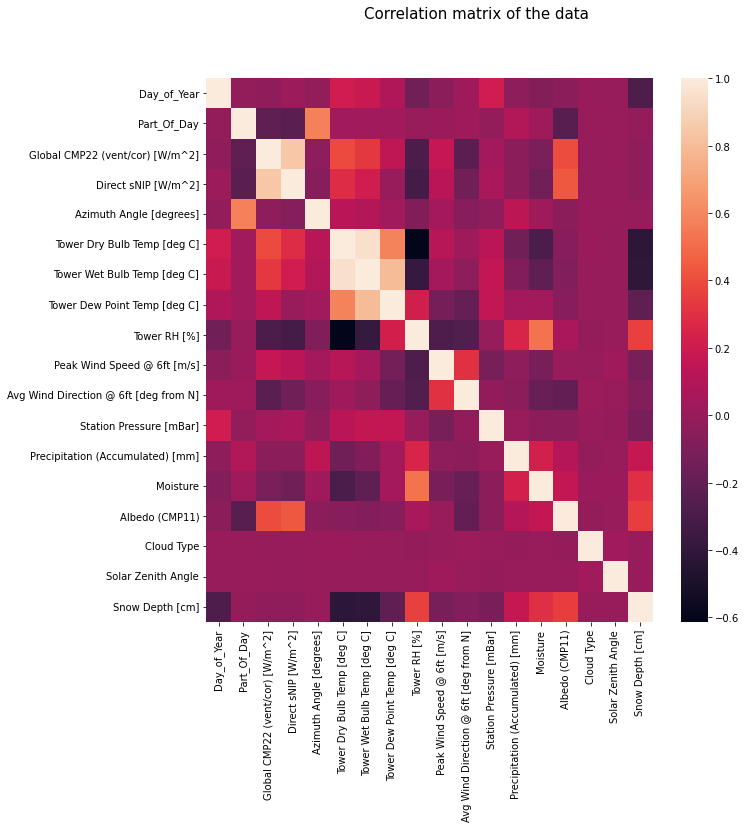

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Correlation matrix of the data", fontsize = 15)
corr = train_x.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            ax = ax)

We observe very high correlation between:
- **Direct sNIP [W/m^2]** and **Global CMP22 (vent/cor) [W/m^2]**
- **Tower Dry Bulb Temp [deg C]**, **Tower Wet Bulb Temp [deg C]** and **Tower Dew Point Temp [deg C]**

We observe very high inverse correlation between:
- **Tower RH [%]** and **Tower Dry Bulb Temp [deg C]**
- **Tower RH [%]** and **Tower Wet Bulb Temp [deg C]**
- **Tower RH [%]** and **Global CMP22 (vent/cor) [W/m^2]**

The following seem to be uncorrelated to **Snow Depth [cm]**: 
- **Global CMP22 (vent/cor) [W/m^2]**
- **Direct sNIP [W/m^2]**
- **Azimuth Angle [degrees]**
- **Cloud Type**
- **Solar Zenith Angle**

### Splitting the Training dataset into training and validation dataset

In [9]:
# shuffle the dataset
train_x = train_x.sample(frac = 1, random_state = 2).reset_index(drop = True) 

# split into training and validation dataset and then split the outputs 
train_x, valid_x = np.array_split(train_x, [int(0.8 * len(train_x))])
valid_x = valid_x.reset_index(drop = True)
train_y = train_x.pop('Snow Depth [cm]') # split the output
valid_y = valid_x.pop('Snow Depth [cm]') # split the output

train_x

,Day_of_Year,Part_Of_Day,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Moisture,Albedo (CMP11),Cloud Type,Solar Zenith Angle
0,235,1,222.753000,259.709000,91.92195,23.790,10.635,-0.965,19.14,0.95,45.02,820.449,0.0,0.0,0.2505,0,36.60
1,365,3,0.127750,-0.227133,241.44062,1.837,-2.200,-8.500,42.48,1.95,21.11,813.285,0.0,0.0,0.0000,4,113.08
2,208,1,467.775000,797.220000,87.29855,19.910,14.663,11.693,59.11,2.70,65.75,824.124,0.0,0.0,0.2124,1,148.00
3,6,4,-1.061650,0.000000,259.21630,2.842,-2.957,-15.157,21.68,1.45,266.20,821.015,0.0,0.0,0.0000,7,61.55
4,323,5,-1.474050,-0.222195,339.05764,5.621,1.808,-2.592,54.05,0.00,0.00,822.400,0.0,0.0,0.0000,3,8.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,170,0,-0.796517,0.207383,37.13578,11.830,9.346,7.546,74.99,0.00,0.00,820.233,0.0,0.0,0.0000,0,83.17
11996,222,3,65.783800,1.377600,277.97696,26.210,15.909,10.119,36.37,3.95,28.82,818.582,0.0,0.0,0.1543,6,40.92
11997,152,1,319.243000,771.288000,77.58285,22.510,12.275,4.975,31.93,2.95,282.20,819.157,0.0,0.0,0.2326,7,108.01
11998,175,3,9.556250,-0.992467,286.61008,23.260,12.674,5.174,30.94,13.95,279.10,815.917,0.0,0.0,0.1441,0,85.30


### Plot graphs for 1 Independent Variable v/s Dependent Variable 
Trying to find if some independent variables are related polynomially rather than linearly to the dependent variable.

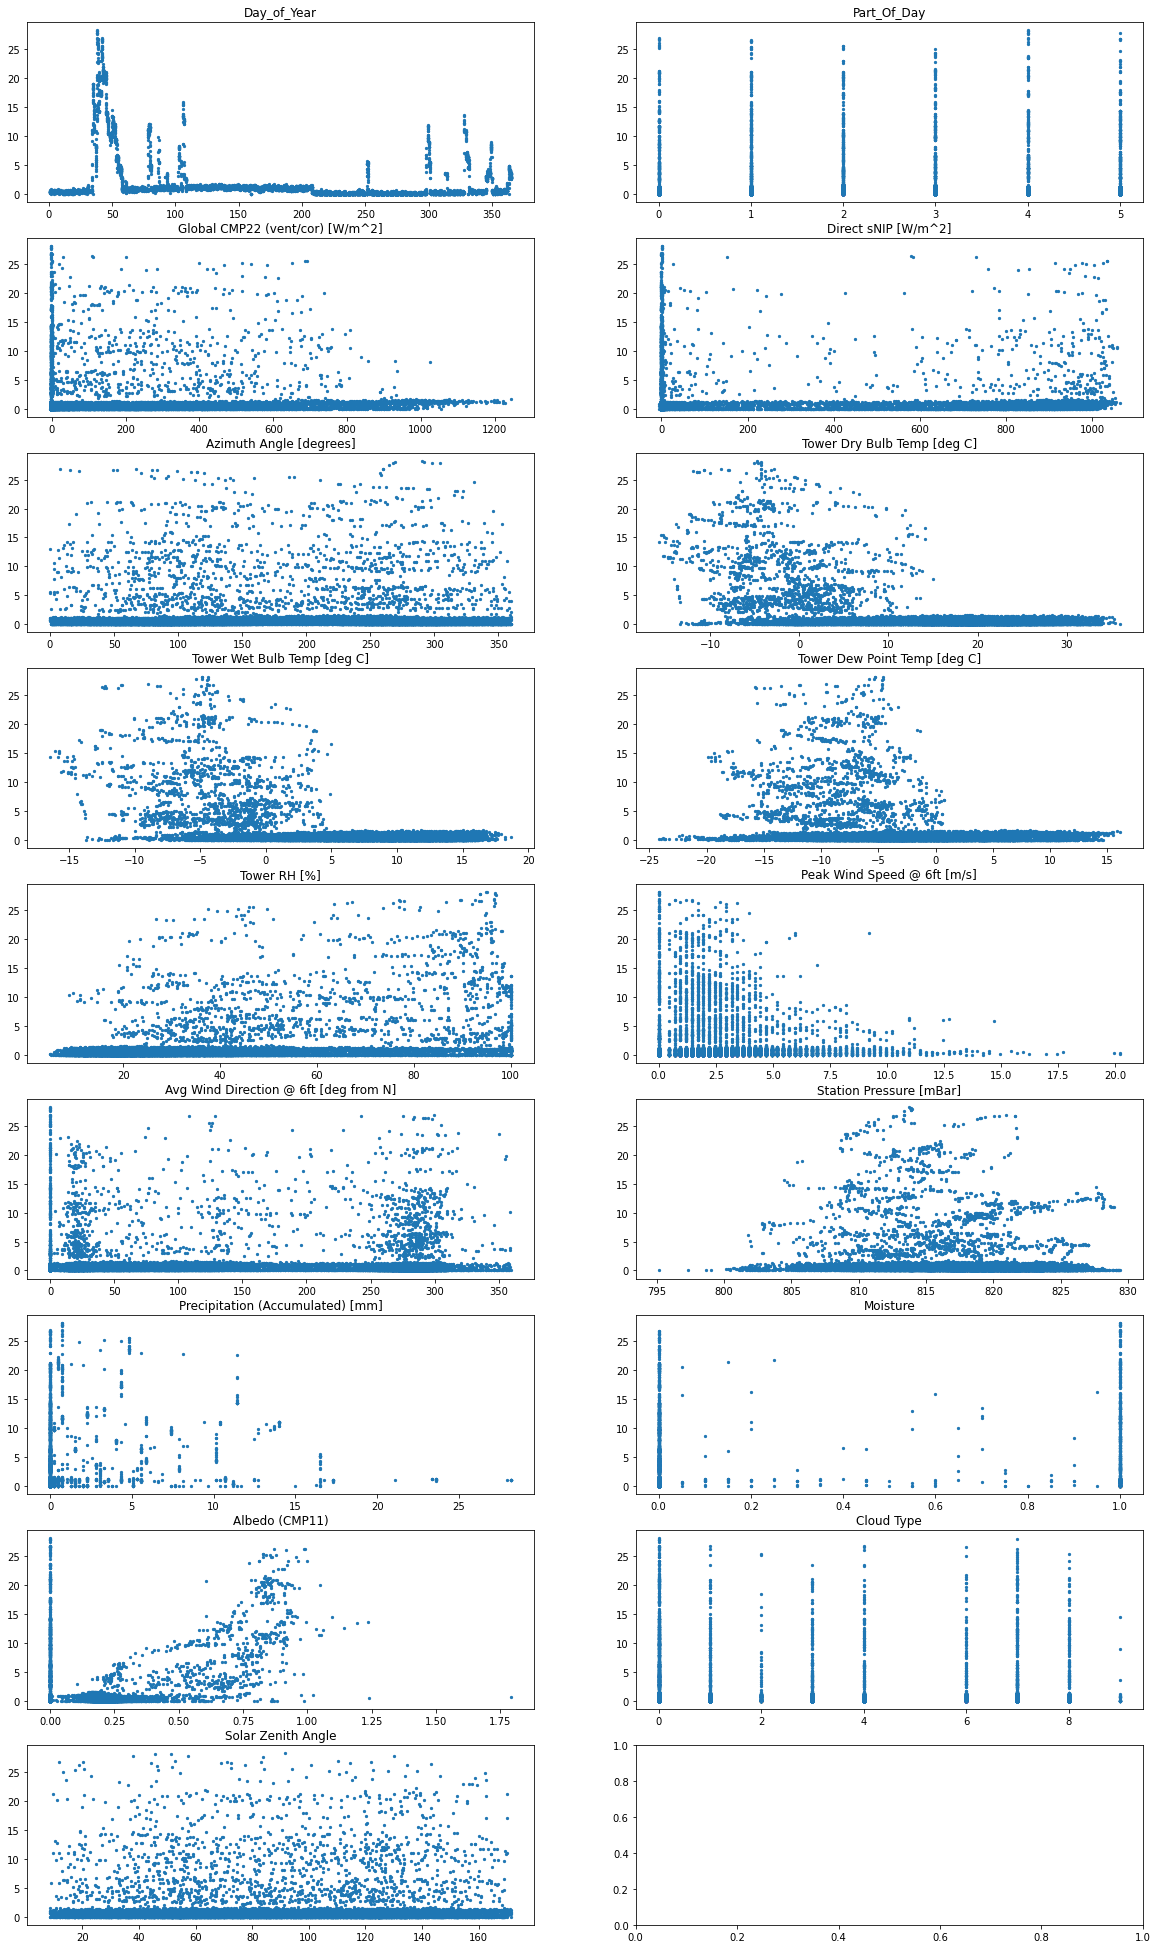

In [14]:
colNames = train_x.columns
f, ax = plt.subplots(9, 2, figsize = (20, 35))
for i in range(len(colNames)):
    x, y = i // 2, i % 2
    ax[x, y].scatter(train_x.iloc[:, i], train_y, s = 5)
    ax[x, y].title.set_text(colNames[i])

No concrete results could be obtained from the above plots.

### Simple Linear Regression: Ordinary Least Squares (OLS)

In [15]:
X = sm.add_constant(train_x)
model_Linear = sm.OLS(train_y, X)
results = model_Linear.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Snow Depth [cm]   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     478.9
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:29:19   Log-Likelihood:                -29639.
No. Observations:               12000   AIC:                         5.931e+04
Df Residuals:                   11982   BIC:                         5.945e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    10.1577      4.415      2.301      0.021       1.504      18.811
Day_of_Year                              -0.0070      0.000    -26.668      0.000      -0.008      -0.007
Part_Of_Day                               0.1472      0.020      7.435      0.000       0.108       0.186
Global CMP22 (vent/cor) [W/m^2]           0.0002      0.000      0.910      0.363      -0.000       0.001
Direct sNIP [W/m^2]                      -0.0003      0.000     -1.740      0.082      -0.001    3.23e-05
Azimuth Angle [degrees]                  -0.0005      0.000     -1.535      0.125      -0.001       0.000
Tower Dry Bulb Temp [deg C]               0.5300      0.021     25.846      0.000       0.490       0.570
Tower Wet Bulb Temp [deg C]              -1.1961      0.043    -27.947      0.000      -1.280      -1.112
Tower Dew Point Temp [deg C]              0.3376      0.021     16.356      0.000       0.297       0.378
Tower RH [%]                              0.0265      0.004      6.909      0.000       0.019       0.034
Peak Wind Speed @ 6ft [m/s]              -0.1758      0.014    -12.403      0.000      -0.204      -0.148
Avg Wind Direction @ 6ft [deg from N]     0.0027      0.000     10.200      0.000       0.002       0.003
Station Pressure [mBar]                  -0.0112      0.005     -2.076      0.038      -0.022      -0.001
Precipitation (Accumulated) [mm]          0.1206      0.015      8.308      0.000       0.092       0.149
Moisture                                  1.0732      0.138      7.776      0.000       0.803       1.344
Albedo (CMP11)                            6.1067      0.173     35.208      0.000       5.767       6.447
Cloud Type                                0.0041      0.009      0.470      0.638      -0.013       0.021
Solar Zenith Angle                        0.0003      0.001      0.511      0.609      -0.001       0.002
==============================================================================
Omnibus:                     7197.769   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111914.090
Skew:                           2.600   Prob(JB):                         0.00
Kurtosis:                      17.028   Cond. No.                     1.60e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the **P>|t|** column (Statistical significance, p-value), we can observe that the variables **Global CMP22 (vent/cor) [W/m^2]**, **Direct sNIP [W/m^2]**, **Azimuth Angle [degrees]**, **Cloud Type** and **Solar Zenith Angle** are statistically ingnificant. 

#### Validating the model

In [16]:
X = sm.add_constant(valid_x)
yvalid = results.predict(X)
print("MAE :", MAE(yvalid, valid_y))

MAE : 1.634987262756241


### Test Results

In [17]:
X = sm.add_constant(test_x)
out_csv = {
    'Id': [i for i in range(len(test_x))],
    'Snow Depth [cm]': results.predict(X)
}

df = pd.DataFrame(out_csv)
df.to_csv('./out/simple_OLS.csv', index = False, encoding = 'utf-8', float_format = '%.3f')

### Simple Linear Regression: Ordinary Least Squares (OLS) with normalised data

In [10]:
cols_not_to_norm = ['Day_of_Year', 'Part_Of_Day', 'Cloud Type']
cols_to_norm = list(train_x.columns)
for i in cols_not_to_norm: cols_to_norm.remove(i)

train_x_norm = train_x.copy()
train_x_norm[cols_to_norm] = StandardScaler().fit_transform(train_x[cols_to_norm])

valid_x_norm = valid_x.copy()
valid_x_norm[cols_to_norm] = StandardScaler().fit_transform(valid_x[cols_to_norm])

test_x_norm = test_x.copy()
test_x_norm[cols_to_norm] = StandardScaler().fit_transform(test_x[cols_to_norm])

In [19]:
X = sm.add_constant(train_x_norm)
model_Linear = sm.OLS(train_y, X)
results = model_Linear.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Snow Depth [cm]   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     478.9
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:29:40   Log-Likelihood:                -29639.
No. Observations:               12000   AIC:                         5.931e+04
Df Residuals:                   11982   BIC:                         5.945e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     2.5545      0.078     32.638      0.000       2.401       2.708
Day_of_Year                              -0.0070      0.000    -26.668      0.000      -0.008      -0.007
Part_Of_Day                               0.1472      0.020      7.435      0.000       0.108       0.186
Global CMP22 (vent/cor) [W/m^2]           0.0515      0.057      0.910      0.363      -0.059       0.162
Direct sNIP [W/m^2]                      -0.0937      0.054     -1.740      0.082      -0.199       0.012
Azimuth Angle [degrees]                  -0.0509      0.033     -1.535      0.125      -0.116       0.014
Tower Dry Bulb Temp [deg C]               5.6340      0.218     25.846      0.000       5.207       6.061
Tower Wet Bulb Temp [deg C]              -8.2489      0.295    -27.947      0.000      -8.827      -7.670
Tower Dew Point Temp [deg C]              2.4575      0.150     16.356      0.000       2.163       2.752
Tower RH [%]                              0.6379      0.092      6.909      0.000       0.457       0.819
Peak Wind Speed @ 6ft [m/s]              -0.3634      0.029    -12.403      0.000      -0.421      -0.306
Avg Wind Direction @ 6ft [deg from N]     0.3149      0.031     10.200      0.000       0.254       0.375
Station Pressure [mBar]                  -0.0567      0.027     -2.076      0.038      -0.110      -0.003
Precipitation (Accumulated) [mm]          0.2335      0.028      8.308      0.000       0.178       0.289
Moisture                                  0.2589      0.033      7.776      0.000       0.194       0.324
Albedo (CMP11)                            1.1147      0.032     35.208      0.000       1.053       1.177
Cloud Type                                0.0041      0.009      0.470      0.638      -0.013       0.021
Solar Zenith Angle                        0.0134      0.026      0.511      0.609      -0.038       0.065
==============================================================================
Omnibus:                     7197.769   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111914.090
Skew:                           2.600   Prob(JB):                         0.00
Kurtosis:                      17.028   Cond. No.                     3.05e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Validating the model

In [20]:
X = sm.add_constant(valid_x_norm)
yvalid = results.predict(X)
print("MAE :", MAE(yvalid, valid_y))

MAE : 1.6226911659314192


### Removing Multicollinearity of Independent Variables (IVs)
#### By plotting Bivariate Graphs:

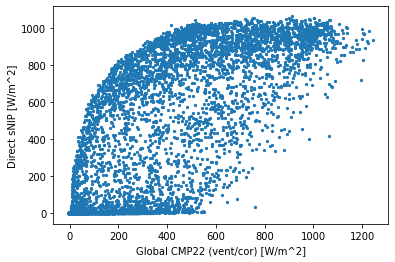

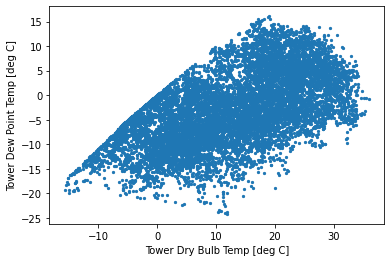

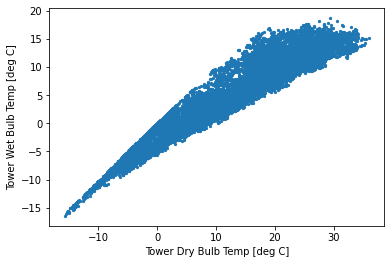

In [21]:
# trying to figure out multi-collinearity
def plot(axis_x, axis_y, data):
    plt.scatter(data[axis_x], data[axis_y], s = 5)
    plt.xlabel(axis_x)
    plt.ylabel(axis_y)
    plt.show()
    plt.close()

# less correlation
plot('Global CMP22 (vent/cor) [W/m^2]', 'Direct sNIP [W/m^2]', train_x) 
plot('Tower Dry Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]', train_x)
# highly correlated
plot('Tower Dry Bulb Temp [deg C]', 'Tower Wet Bulb Temp [deg C]', train_x)  

#### By calculating the Variance Inflation Factor (VIF)

In [11]:
def VIF(y, x):
    model = sm.OLS(y, x) # put into model 
    results = model.fit() # pass through the model
    # print(results.summary())
    rsq = results.rsquared # R^2 metric to determine the fit 
    return round(1 / (1 - rsq), 2) # VIF

def get_VIF_for_IVs(xtrain):
    df = pd.DataFrame(columns = ['Name', 'vif'])
    colNames = xtrain.columns
    vifValues = []
    for name in colNames: 
        x = xtrain.copy()
        y = x.pop(name) 
        vifValues.append(VIF(y, x))
    df.Name = colNames
    df.vif = vifValues
    print(df)

In [71]:
xtrain = train_x_norm.copy()
get_VIF_for_IVs(xtrain)

                                     Name     vif
0                             Day_of_Year    2.69
1                             Part_Of_Day    3.01
2         Global CMP22 (vent/cor) [W/m^2]    4.59
3                     Direct sNIP [W/m^2]    4.24
4                 Azimuth Angle [degrees]    1.41
5             Tower Dry Bulb Temp [deg C]   69.29
6             Tower Wet Bulb Temp [deg C]  127.57
7            Tower Dew Point Temp [deg C]   33.03
8                            Tower RH [%]   12.44
9             Peak Wind Speed @ 6ft [m/s]    1.26
10  Avg Wind Direction @ 6ft [deg from N]    1.40
11                Station Pressure [mBar]    1.08
12       Precipitation (Accumulated) [mm]    1.16
13                               Moisture    1.62
14                         Albedo (CMP11)    1.45
15                             Cloud Type    1.57
16                     Solar Zenith Angle    1.00


In [72]:
# Few Independent variables have very high VIF
# Let's try popping them out
xtrain.drop(['Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]', 'Tower Dry Bulb Temp [deg C]'], inplace = True, axis = 1)
get_VIF_for_IVs(xtrain)

                                     Name   vif
0                             Day_of_Year  2.65
1                             Part_Of_Day  2.99
2         Global CMP22 (vent/cor) [W/m^2]  3.83
3                     Direct sNIP [W/m^2]  3.89
4                 Azimuth Angle [degrees]  1.39
5                            Tower RH [%]  1.87
6             Peak Wind Speed @ 6ft [m/s]  1.24
7   Avg Wind Direction @ 6ft [deg from N]  1.38
8                 Station Pressure [mBar]  1.06
9        Precipitation (Accumulated) [mm]  1.14
10                               Moisture  1.46
11                         Albedo (CMP11)  1.40
12                             Cloud Type  1.56
13                     Solar Zenith Angle  1.00


### Simple Linear Regression: Ordinary Least Squares (OLS) after VIF check

In [74]:
X = sm.add_constant(xtrain)
model_Linear = sm.OLS(train_y, X)
results = model_Linear.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Snow Depth [cm]   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     387.2
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:59:13   Log-Likelihood:                -30511.
No. Observations:               12000   AIC:                         6.105e+04
Df Residuals:                   11985   BIC:                         6.116e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     2.7371      0.083     32.898      0.000       2.574       2.900
Day_of_Year                              -0.0079      0.000    -28.334      0.000      -0.008      -0.007
Part_Of_Day                               0.1337      0.021      6.286      0.000       0.092       0.175
Global CMP22 (vent/cor) [W/m^2]          -0.1362      0.055     -2.465      0.014      -0.244      -0.028
Direct sNIP [W/m^2]                      -0.1108      0.055     -2.000      0.046      -0.219      -0.002
Azimuth Angle [degrees]                  -0.0502      0.036     -1.412      0.158      -0.120       0.019
Tower RH [%]                              0.7893      0.039     20.436      0.000       0.714       0.865
Peak Wind Speed @ 6ft [m/s]              -0.3376      0.031    -10.764      0.000      -0.399      -0.276
Avg Wind Direction @ 6ft [deg from N]     0.3352      0.033     10.146      0.000       0.270       0.400
Station Pressure [mBar]                  -0.1953      0.029     -6.707      0.000      -0.252      -0.138
Precipitation (Accumulated) [mm]          0.1469      0.030      4.895      0.000       0.088       0.206
Moisture                                  0.3452      0.034     10.180      0.000       0.279       0.412
Albedo (CMP11)                            1.3503      0.034     40.293      0.000       1.285       1.416
Cloud Type                                0.0071      0.009      0.765      0.445      -0.011       0.025
Solar Zenith Angle                        0.0073      0.028      0.259      0.796      -0.048       0.062
==============================================================================
Omnibus:                     7961.864   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124790.786
Skew:                           3.000   Prob(JB):                         0.00
Kurtosis:                      17.614   Cond. No.                         649.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Validating the model

In [75]:
xvalid = valid_x_norm.copy()
xvalid.drop(['Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]', 'Tower Dry Bulb Temp [deg C]'], inplace = True, axis = 1)

X = sm.add_constant(xvalid)
yvalid = results.predict(X)
print("MAE :", MAE(yvalid, valid_y))

MAE : 1.7497443476409504


The results have deteriorated after removing IVs with high VIF.

### Test Results

In [76]:
xtest = test_x_norm.copy()
xtest.drop(['Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]', 'Tower Dry Bulb Temp [deg C]'], inplace = True, axis = 1)

X = sm.add_constant(xtest)
out_csv = {
    'Id': [i for i in range(len(xtest))],
    'Snow Depth [cm]': results.predict(X)
}

df = pd.DataFrame(out_csv)
df.to_csv('./out/OLS_vif.csv', index = False, encoding = 'utf-8', float_format = '%.3f')

### Handling correlation between Independent Variables and removing insignificant ones

In [12]:
dropped_cols = ['Global CMP22 (vent/cor) [W/m^2]', 'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]', 'Cloud Type', 'Solar Zenith Angle', 'Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]', 'Tower Dry Bulb Temp [deg C]']

xtrain_corr = train_x_norm.copy()
xtrain_corr.drop(dropped_cols, inplace = True, axis = 1)

xvalid_corr = valid_x_norm.copy()
xvalid_corr.drop(dropped_cols, inplace = True, axis = 1)

xtest_corr = test_x_norm.copy()
xtest_corr.drop(dropped_cols, inplace = True, axis = 1)


cols_to_invert = ['Tower Wet Bulb Temp [deg C]', 'Tower Dew Point Temp [deg C]', 'Tower Dry Bulb Temp [deg C]']

inverted_cols = ['Inv Tower Wet Bulb Temp [1/K]', 'Inv Tower Dew Point Temp [1/K]', 'Inv Tower Dry Bulb Temp [1/K]']

temp_inv = lambda x: 1 / (x + 273.16) # converted to Kelvin and took inverse

xtrain_corr[inverted_cols] = StandardScaler().fit_transform(train_x_norm[cols_to_invert].apply(temp_inv))

xvalid_corr[inverted_cols] = StandardScaler().fit_transform(valid_x_norm[cols_to_invert].apply(temp_inv))

xtest_corr[inverted_cols] = StandardScaler().fit_transform(test_x_norm[cols_to_invert].apply(temp_inv))

In [44]:
X = sm.add_constant(xtrain_corr)
model_Linear = sm.OLS(train_y, X)
results = model_Linear.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Snow Depth [cm]   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     680.0
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:06:35   Log-Likelihood:                -29634.
No. Observations:               12000   AIC:                         5.929e+04
Df Residuals:                   11987   BIC:                         5.939e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     2.6019      0.069     37.960      0.000       2.468       2.736
Day_of_Year                              -0.0070      0.000    -27.013      0.000      -0.008      -0.007
Part_Of_Day                               0.1326      0.016      8.276      0.000       0.101       0.164
Tower RH [%]                              0.6723      0.092      7.289      0.000       0.492       0.853
Peak Wind Speed @ 6ft [m/s]              -0.3640      0.029    -12.736      0.000      -0.420      -0.308
Avg Wind Direction @ 6ft [deg from N]     0.3239      0.029     10.982      0.000       0.266       0.382
Station Pressure [mBar]                  -0.0608      0.027     -2.237      0.025      -0.114      -0.008
Precipitation (Accumulated) [mm]          0.2291      0.028      8.232      0.000       0.175       0.284
Moisture                                  0.2597      0.033      7.836      0.000       0.195       0.325
Albedo (CMP11)                            1.0894      0.028     38.328      0.000       1.034       1.145
Inv Tower Wet Bulb Temp [1/K]             8.3149      0.284     29.323      0.000       7.759       8.871
Inv Tower Dew Point Temp [1/K]           -2.4636      0.145    -16.948      0.000      -2.749      -2.179
Inv Tower Dry Bulb Temp [1/K]            -5.7004      0.209    -27.280      0.000      -6.110      -5.291
==============================================================================
Omnibus:                     7180.271   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110870.049
Skew:                           2.594   Prob(JB):                         0.00
Kurtosis:                      16.958   Cond. No.                     2.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
X = sm.add_constant(xvalid_corr)
yvalid = results.predict(X)
print("MAE :", MAE(yvalid, valid_y))

X = sm.add_constant(xtest_corr)
out_csv = {
    'Id': [i for i in range(len(xtest))],
    'Snow Depth [cm]': results.predict(X)
}

df = pd.DataFrame(out_csv)
df.to_csv('./out/OLS_corr.csv', index = False, encoding = 'utf-8', float_format = '%.3f')

MAE : 1.624534278751495


### Regression: Deep Learning (ANN)

In [13]:
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, x, y):
        # store the inputs(x) and outputs (y)
        self.x = Tensor(x.to_numpy().astype('float32'))
        self.y = Tensor(y.to_numpy().astype('float32'))
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))
        self.length = len(x)

    # number of rows in the dataset
    def __len__(self): return self.length

    # get a row at an index
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

# model0 definition
class MLP0(Module):
    # define model elements
    def __init__(self, n_inputs):
        super().__init__()

        # the input layer 
        self.input = Linear(n_inputs, 60)
        # xavier_uniform_(self.input.weight)
        kaiming_uniform_(self.input.weight)
        # self.act0 = ReLU()  
        self.act0 = Sigmoid()  

        # first hidden layer
        self.hidden1 = Linear(60, 30)
        # xavier_uniform_(self.hidden1.weight)
        kaiming_uniform_(self.hidden1.weight)
        # self.act1 = ReLU()
        self.act1 = Sigmoid()

        # second hidden layer
        self.hidden2 = Linear(30, 15)
        # xavier_uniform_(self.hidden2.weight)
        kaiming_uniform_(self.hidden2.weight)
        # self.act2 = ReLU()
        self.act2 = Sigmoid()

        # output layer
        self.output = Linear(15, 1)
        # xavier_uniform_(self.output.weight)
        kaiming_uniform_(self.output.weight)

    # forward propagate input
    def forward(self, X):
        # input to the input layer 
        X = self.input(X)
        X = self.act0(X)       
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # input to second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # input to the output layer
        X = self.output(X)
        return X

# model1 definition
class MLP1(Module):
    # define model elements
    def __init__(self, n_inputs):
        super().__init__()

        # the input layer 
        self.input = Linear(n_inputs, 50)
        # xavier_uniform_(self.input.weight)
        kaiming_uniform_(self.input.weight)
        # self.act0 = ReLU()  
        self.act0 = Sigmoid()  

        # first hidden layer
        self.hidden1 = Linear(50, 80)
        # xavier_uniform_(self.hidden1.weight)
        kaiming_uniform_(self.hidden1.weight)
        # self.act1 = ReLU()
        self.act1 = Sigmoid()

        # second hidden layer
        self.hidden2 = Linear(80, 40)
        # xavier_uniform_(self.hidden2.weight)
        kaiming_uniform_(self.hidden2.weight)
        # self.act2 = ReLU()
        self.act2 = Sigmoid()

        # third hidden layer
        self.hidden3 = Linear(40, 15)
        # xavier_uniform_(self.hidden2.weight)
        kaiming_uniform_(self.hidden3.weight)
        # self.act3 = ReLU()
        self.act3 = Sigmoid()

        # output layer
        self.output = Linear(15, 1)
        # xavier_uniform_(self.output.weight)
        kaiming_uniform_(self.output.weight)

    # forward propagate input
    def forward(self, X):
        # input to the input layer 
        X = self.input(X)
        X = self.act0(X)       
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # input to second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # input to third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # input to the output layer
        X = self.output(X)
        return X

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = MSELoss()
    # optimizer = SGD(model.parameters(), lr = 0.0001, momentum = 0.7)
    optimizer = Adam(model.parameters(), lr = 0.0001)
    # optimizer = RAdam(model.parameters(), lr = 0.0001)
    
    # enumerate epochs
    
    with trange(200, unit = 'epochs') as tepoch:
        for epoch in tepoch:
        # with tqdm(train_dl, unit="batch") as tepoch:
            # enumerate mini batches
            for inputs, targets in train_dl:
                # tepoch.set_description(f"Epoch {epoch}")
                # clear the gradients
                optimizer.zero_grad()
                # compute the model output
                y_out = model(inputs)
                # calculate loss
                loss = criterion(y_out, targets)
                # credit assignment
                loss.backward()
                # update model weights
                optimizer.step()
        print("Completed {} epochs with Training loss: {}.".format(epoch + 1, loss.item()))

# evaluate the model
def evaluate_model(valid_dl, model):
    predictions, actuals = np.empty([1, 0]), np.empty([1, 0])
    with tqdm(valid_dl, unit="batch") as teval:
        for inputs, targets in teval:
            teval.set_description("Validation")
            # evaluate the model on the test set
            y_out = model(inputs)
            # retrieve numpy array
            y_out = y_out.detach().numpy()
            targets = targets.numpy()
            targets = targets.reshape((len(targets), 1))
            # store
            predictions = np.append(predictions, y_out)
            actuals = np.append(actuals, targets)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate MAE
    mae = MAE(actuals, predictions)[0]
    return mae

In [14]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor(row)
    # make prediction
    y_out = model(row)
    # retrieve numpy array
    y_out = y_out.detach().numpy()
    return y_out[0]

#### DL Model

In [65]:
# prepare the data
train_dl = CSVDataset(train_x_norm, train_y)
valid_dl = CSVDataset(valid_x_norm, valid_y)
train_dl = DataLoader(train_dl, batch_size = 64, shuffle = True)
valid_dl = DataLoader(valid_dl, batch_size = 128, shuffle = False)
print(len(train_dl.dataset), len(valid_dl.dataset))

model0 = MLP0(17) # define the network
train_model(train_dl, model0) # train the model
print('\n', summary(model0, (64, 1, 17)))

model1 = MLP1(17) # define the network
train_model(train_dl, model1) # train the model
print('\n', summary(model1, (64, 1, 17)))

12000 3000


100%|██████████| 200/200 [01:20<00:00,  2.50epochs/s]


Completed 200 epochs with Training loss: 3.578464984893799.

Layer (type:depth-idx)                   Output Shape              Param #
MLP0                                     --                        --
├─Linear: 1-1                            [64, 1, 60]               1,080
├─Sigmoid: 1-2                           [64, 1, 60]               --
├─Linear: 1-3                            [64, 1, 30]               1,830
├─Sigmoid: 1-4                           [64, 1, 30]               --
├─Linear: 1-5                            [64, 1, 15]               465
├─Sigmoid: 1-6                           [64, 1, 15]               --
├─Linear: 1-7                            [64, 1, 1]                16
Total params: 3,391
Trainable params: 3,391
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.07


100%|██████████| 200/200 [01:55<00:00,  1.74epochs/s]

Completed 200 epochs with Training loss: 0.5503991842269897.

Layer (type:depth-idx)                   Output Shape              Param #
MLP1                                     --                        --
├─Linear: 1-1                            [64, 1, 50]               900
├─Sigmoid: 1-2                           [64, 1, 50]               --
├─Linear: 1-3                            [64, 1, 80]               4,080
├─Sigmoid: 1-4                           [64, 1, 80]               --
├─Linear: 1-5                            [64, 1, 40]               3,240
├─Sigmoid: 1-6                           [64, 1, 40]               --
├─Linear: 1-7                            [64, 1, 15]               615
├─Sigmoid: 1-8                           [64, 1, 15]               --
├─Linear: 1-9                            [64, 1, 1]                16
Total params: 8,851
Trainable params: 8,851
Non-trainable params: 0
Total mult-adds (M): 0.57
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
P

In [66]:
mae = evaluate_model(valid_dl, model0) # evaluate the model
print('MAE model0: {}'.format(mae))

mae = evaluate_model(valid_dl, model1) # evaluate the model
print('MAE model1: {}'.format(mae))

Validation: 100%|██████████| 24/24 [00:00<00:00, 230.92batch/s]


MAE model0: 0.9714840611305166


Validation: 100%|██████████| 24/24 [00:00<00:00, 196.35batch/s]


MAE model1: 0.9529791184153485


In [77]:
l = len(test_x_norm)
out_csv = {
    'Id': [i for i in range(l)],
    'Snow Depth [cm]': [predict(test_x_norm.iloc[i].to_numpy().astype('float32'), model1) for i in range(l)]
}

df = pd.DataFrame(out_csv)
df.to_csv('./out/model1_normal.csv', index = False, encoding = 'utf-8', float_format = '%.3f')

#### DL Model after removing IVs with high VIF

In [82]:
train_dl = CSVDataset(xtrain, train_y)
valid_dl = CSVDataset(xvalid, valid_y)
train_dl = DataLoader(train_dl, batch_size = 64, shuffle = True)
valid_dl = DataLoader(valid_dl, batch_size = 128, shuffle = False)
print(len(train_dl.dataset), len(valid_dl.dataset))

model0 = MLP0(14) # define the network
train_model(train_dl, model0) # train the model
print('\n', summary(model0, (64, 1, 14)))

model1 = MLP1(14) # define the network
train_model(train_dl, model1) # train the model
print('\n', summary(model1, (64, 1, 14)))

12000 3000


100%|██████████| 200/200 [00:51<00:00,  3.90epochs/s]


Completed 200 epochs with Training loss: 8.094718933105469.

Layer (type:depth-idx)                   Output Shape              Param #
MLP0                                     --                        --
├─Linear: 1-1                            [64, 1, 60]               900
├─Sigmoid: 1-2                           [64, 1, 60]               --
├─Linear: 1-3                            [64, 1, 30]               1,830
├─Sigmoid: 1-4                           [64, 1, 30]               --
├─Linear: 1-5                            [64, 1, 15]               465
├─Sigmoid: 1-6                           [64, 1, 15]               --
├─Linear: 1-7                            [64, 1, 1]                16
Total params: 3,211
Trainable params: 3,211
Non-trainable params: 0
Total mult-adds (M): 0.21
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.07


100%|██████████| 200/200 [01:19<00:00,  2.52epochs/s]

Completed 200 epochs with Training loss: 1.6516220569610596.

Layer (type:depth-idx)                   Output Shape              Param #
MLP1                                     --                        --
├─Linear: 1-1                            [64, 1, 50]               750
├─Sigmoid: 1-2                           [64, 1, 50]               --
├─Linear: 1-3                            [64, 1, 80]               4,080
├─Sigmoid: 1-4                           [64, 1, 80]               --
├─Linear: 1-5                            [64, 1, 40]               3,240
├─Sigmoid: 1-6                           [64, 1, 40]               --
├─Linear: 1-7                            [64, 1, 15]               615
├─Sigmoid: 1-8                           [64, 1, 15]               --
├─Linear: 1-9                            [64, 1, 1]                16
Total params: 8,701
Trainable params: 8,701
Non-trainable params: 0
Total mult-adds (M): 0.56
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
P

In [83]:
mae = evaluate_model(valid_dl, model0) # evaluate the model
print('MAE model0: {}'.format(mae))

mae = evaluate_model(valid_dl, model1) # evaluate the model
print('MAE model1: {}'.format(mae))

Validation: 100%|██████████| 24/24 [00:00<00:00, 258.07batch/s]


MAE model0: 0.9969428386578414


Validation: 100%|██████████| 24/24 [00:00<00:00, 187.45batch/s]


MAE model1: 0.9351901566968688


In [84]:
l = len(xtest)
out_csv = {
    'Id': [i for i in range(l)],
    'Snow Depth [cm]': [predict(xtest.iloc[i].to_numpy().astype('float32'), model1) for i in range(l)]
}

df = pd.DataFrame(out_csv)
df.to_csv('./out/model1_vif.csv', index = False, encoding = 'utf-8', float_format = '%.3f')

### DL Model after handling correlation between Independent Variables and removing insignificant ones

In [15]:
train_dl = CSVDataset(xtrain_corr, train_y)
valid_dl = CSVDataset(xvalid_corr, valid_y)
train_dl = DataLoader(train_dl, batch_size = 64, shuffle = True)
valid_dl = DataLoader(valid_dl, batch_size = 128, shuffle = False)
print(len(train_dl.dataset), len(valid_dl.dataset))

model0 = MLP0(12) # define the network
train_model(train_dl, model0) # train the model
print('\n', summary(model0, (64, 1, 12)))

model1 = MLP1(12) # define the network
train_model(train_dl, model1) # train the model
print('\n', summary(model1, (64, 1, 12)))

12000 3000


100%|██████████| 200/200 [01:06<00:00,  2.99epochs/s]


Completed 200 epochs with Training loss: 1.6768946647644043.

Layer (type:depth-idx)                   Output Shape              Param #
MLP0                                     --                        --
├─Linear: 1-1                            [64, 1, 60]               780
├─Sigmoid: 1-2                           [64, 1, 60]               --
├─Linear: 1-3                            [64, 1, 30]               1,830
├─Sigmoid: 1-4                           [64, 1, 30]               --
├─Linear: 1-5                            [64, 1, 15]               465
├─Sigmoid: 1-6                           [64, 1, 15]               --
├─Linear: 1-7                            [64, 1, 1]                16
Total params: 3,091
Trainable params: 3,091
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.07


100%|██████████| 200/200 [01:41<00:00,  1.97epochs/s]

Completed 200 epochs with Training loss: 8.86832046508789.

Layer (type:depth-idx)                   Output Shape              Param #
MLP1                                     --                        --
├─Linear: 1-1                            [64, 1, 50]               650
├─Sigmoid: 1-2                           [64, 1, 50]               --
├─Linear: 1-3                            [64, 1, 80]               4,080
├─Sigmoid: 1-4                           [64, 1, 80]               --
├─Linear: 1-5                            [64, 1, 40]               3,240
├─Sigmoid: 1-6                           [64, 1, 40]               --
├─Linear: 1-7                            [64, 1, 15]               615
├─Sigmoid: 1-8                           [64, 1, 15]               --
├─Linear: 1-9                            [64, 1, 1]                16
Total params: 8,601
Trainable params: 8,601
Non-trainable params: 0
Total mult-adds (M): 0.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Par

In [16]:
mae = evaluate_model(valid_dl, model0) # evaluate the model
print('MAE model0: {}'.format(mae))

mae = evaluate_model(valid_dl, model1) # evaluate the model
print('MAE model1: {}'.format(mae))

Validation: 100%|██████████| 24/24 [00:00<00:00, 243.50batch/s]


MAE model0: 0.9240292712461281


Validation: 100%|██████████| 24/24 [00:00<00:00, 280.60batch/s]


MAE model1: 0.9756068879054316


In [18]:
l = len(xtest_corr)
out_csv = {
    'Id': [i for i in range(l)],
    'Snow Depth [cm]': [predict(xtest_corr.iloc[i].to_numpy().astype('float32'), model0) for i in range(l)]
}

df = pd.DataFrame(out_csv)
df.to_csv('./out/model0_corr.csv', index = False, encoding = 'utf-8', float_format = '%.3f')